In [1]:
!pip install pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 10.0 MB/s eta 0:00:00


In [2]:
import os
from google.colab import files
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torch.distributions as td
from torch.distributions import constraints
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import pyro
import pyro.poutine as poutine
import pyro.distributions as dist
from pyro.distributions import TransformedDistribution
from pyro.distributions.torch_distribution import TorchDistribution
from pyro.distributions.transforms import affine_autoregressive
from pyro.infer import (
    SVI,
    JitTrace_ELBO,
    Trace_ELBO,
    TraceEnum_ELBO,
    TraceTMC_ELBO,
    config_enumerate,
)
from pyro.optim import (
    Adam,
    ClippedAdam,
)

# Generate Data

In [3]:
# ============================================================
# Utils: padding + reverse padded sequence
# ============================================================

def reverse_padded_sequence(seq: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
    """
    Reverse each sequence up to its length, keep padding (zeros).
    seq: (B, T, D)
    lengths: (B,)
    """
    B, T, D = seq.shape
    out = seq.clone()
    for i in range(B):
        L = int(lengths[i].item())
        if L > 0:
            out[i, :L, :] = torch.flip(seq[i, :L, :], dims=[0])
        if L < T:
            out[i, L:, :] = 0.0
    return out


# ============================================================
# 1) Simulator Dataset: variable-length, categorical a, Bernoulli y
# ============================================================

def sigmoid_np(x):
    return 1.0 / (1.0 + np.exp(-x))


class SimDataset(Dataset):
    """
    Returns a tuple:
      x: (T_i, dim_x) float32
      a: (T_i,) long in {0..K-1}
      y: (1,) float32 in {0,1}
      z: (T_i, dim_z) float32  (diagnostics only)
      length: scalar long
    """
    def __init__(
        self,
        num_sequences=3000,
        min_T=3,
        max_T=15,
        dim_x=20,
        dim_z=3,
        num_actions=6,
        seed=0,
        clip_z=10.0,
        x_scale=0.15,
        z_scale=0.15,
        a_strength=0.15,   # dependence of a on z
    ):
        super().__init__()
        assert 1 <= min_T <= max_T
        self.min_T = int(min_T)
        self.max_T = int(max_T)
        self.dim_x = int(dim_x)
        self.dim_z = int(dim_z)
        self.K = int(num_actions)
        self.clip_z = float(clip_z)

        rng = np.random.RandomState(seed)

        # --- a_t | z_t ---
        # Base probs: cat0=0.8, others equally share 0.2.
        base_probs = np.array([0.8] + [0.2 / (self.K - 1)] * (self.K - 1), dtype=np.float32)
        self.base_logits_a = np.log(base_probs + 1e-12)  # (K,)
        self.W_a = rng.randn(self.K, self.dim_z).astype(np.float32) * float(a_strength)

        # --- z_{t+1} | z_t, a_t ---
        # simulator uses one-hot a_t
        self.W_z = rng.randn(self.dim_z, self.dim_z + self.K).astype(np.float32) * 0.15
        self.b_z = rng.randn(self.dim_z).astype(np.float32) * 0.05
        self.z_scale = np.ones(self.dim_z, dtype=np.float32) * float(z_scale)

        # --- x_t | z_t, z_{t-1} ---
        self.W_x = rng.randn(self.dim_x, 2 * self.dim_z).astype(np.float32) * 0.25
        self.b_x = rng.randn(self.dim_x).astype(np.float32) * 0.05
        self.x_scale = np.ones(self.dim_x, dtype=np.float32) * float(x_scale)

        # --- y | z_T, a_T ---
        self.w_y = rng.randn(self.dim_z + self.K).astype(np.float32) * 0.4
        self.b_y = float(rng.randn() * 0.05)

        self.data = [self._sample_one(rng) for _ in range(int(num_sequences))]

    def _sample_one(self, rng):
        T = int(rng.randint(self.min_T, self.max_T + 1))

        z = np.zeros((T, self.dim_z), dtype=np.float32)
        a = np.zeros((T,), dtype=np.int64)
        x = np.zeros((T, self.dim_x), dtype=np.float32)

        # z_1
        z[0] = rng.randn(self.dim_z).astype(np.float32)
        z_prev_for_x = np.zeros(self.dim_z, dtype=np.float32)  # z_0=0 for x_1

        for t in range(T):
            # a_t | z_t
            logits_a = self.base_logits_a + (self.W_a @ z[t])  # (K,)
            probs = np.exp(logits_a - logits_a.max())
            probs = probs / probs.sum()
            a[t] = rng.choice(self.K, p=probs)

            # x_t | z_t, z_{t-1}
            zx = np.concatenate([z[t], z_prev_for_x], axis=0)  # (2*dim_z,)
            x_loc = self.W_x @ zx + self.b_x
            x[t] = (x_loc + self.x_scale * rng.randn(self.dim_x)).astype(np.float32)

            # z_{t+1} | z_t, a_t
            if t < T - 1:
                a_onehot = np.zeros(self.K, dtype=np.float32)
                a_onehot[a[t]] = 1.0
                za = np.concatenate([z[t], a_onehot], axis=0)  # (dim_z+K,)
                z_loc = self.W_z @ za + self.b_z
                z_next = (z_loc + self.z_scale * rng.randn(self.dim_z)).astype(np.float32)
                z[t + 1] = np.clip(z_next, -self.clip_z, self.clip_z)

            z_prev_for_x = z[t].copy()

        # y | z_T, a_T
        aT_onehot = np.zeros(self.K, dtype=np.float32)
        aT_onehot[a[T - 1]] = 1.0
        zaT = np.concatenate([z[T - 1], aT_onehot], axis=0)
        y_logit = float(self.w_y @ zaT + self.b_y)
        y_prob = sigmoid_np(y_logit)
        y = np.array([rng.binomial(1, y_prob)], dtype=np.float32)

        length = T
        return x, a, y, z, length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, a, y, z, length = self.data[idx]
        return (
            torch.tensor(x, dtype=torch.float32),      # (T, dim_x)
            torch.tensor(a, dtype=torch.long),         # (T,)
            torch.tensor(y, dtype=torch.float32),      # (1,)
            torch.tensor(z, dtype=torch.float32),      # (T, dim_z) diagnostics only
            torch.tensor(length, dtype=torch.long),    # scalar
        )


def pad_collate_varlen_cat_a(batch, pad_action=0):
    """
    Pads variable-length sequences in a batch.

    Returns:
      x_pad:   (B, T_max, dim_x) float32
      a_pad:   (B, T_max) long   (pad with pad_action)
      y:       (B, 1) float32
      z_pad:   (B, T_max, dim_z) float32 (diagnostics only)
      lengths: (B,) long
      mask:    (B, T_max) bool
    """
    xs, aas, ys, zs, lens = zip(*batch)
    lengths = torch.stack(lens, dim=0)  # (B,)
    B = len(batch)
    T_max = int(lengths.max().item())
    dim_x = xs[0].shape[-1]
    dim_z = zs[0].shape[-1]

    x_pad = torch.zeros(B, T_max, dim_x, dtype=torch.float32)
    a_pad = torch.full((B, T_max), fill_value=int(pad_action), dtype=torch.long)
    z_pad = torch.zeros(B, T_max, dim_z, dtype=torch.float32)
    y = torch.stack(ys, dim=0).reshape(B, 1)

    for i, (x_i, a_i, z_i, L) in enumerate(zip(xs, aas, zs, lengths)):
        L = int(L.item())
        x_pad[i, :L, :] = x_i
        a_pad[i, :L] = a_i
        z_pad[i, :L, :] = z_i

    t = torch.arange(T_max).unsqueeze(0).expand(B, T_max)
    mask = t < lengths.unsqueeze(1)  # (B, T_max)
    return x_pad, a_pad, y, z_pad, lengths, mask


In [4]:
# what does the dataset look like?

full_dataset = SimDataset(
    num_sequences=3000,
    min_T=3,
    max_T=15,
    dim_x=20,
    dim_z=3,
    num_actions=6,
    seed=0,
)

n_total = len(full_dataset)
n_train = int(0.8 * n_total)
n_test = n_total - n_train
train_dataset, test_dataset = random_split(full_dataset, [n_train, n_test])

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=pad_collate_varlen_cat_a,
    drop_last=False,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    collate_fn=pad_collate_varlen_cat_a,
    drop_last=False,
)

# sanity check
x, a, y, z, lengths, mask = next(iter(train_loader))
print("x:", x.shape, "a:", a.shape, "y:", y.shape, "z:", z.shape)
print("lengths[:10]:", lengths[:10].tolist(), "T_max:", x.size(1))
binc = torch.bincount(a[mask].flatten(), minlength=6).float()
print("a freq in batch:", binc / binc.sum())

x: torch.Size([32, 15, 20]) a: torch.Size([32, 15]) y: torch.Size([32, 1]) z: torch.Size([32, 15, 3])
lengths[:10]: [12, 14, 14, 15, 5, 12, 10, 10, 10, 6] T_max: 15
a freq in batch: tensor([0.8322, 0.0140, 0.0455, 0.0280, 0.0420, 0.0385])


# Transfusion-ITE

In [7]:
# ============================================================
# 2) Neural components
# ============================================================

class MLPNormal(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim, min_scale=0.1, max_scale=0.8):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.loc = nn.Linear(hidden_dim, out_dim)
        self.scale = nn.Linear(hidden_dim, out_dim)
        self.tanh = nn.Tanh()
        self.softplus = nn.Softplus()
        self.min_scale = float(min_scale)
        self.max_scale = float(max_scale)

    def forward(self, x):
        h = self.tanh(self.fc1(x))
        h = self.tanh(self.fc2(h))
        loc = self.loc(h)
        scale = (self.softplus(self.scale(h)) + self.min_scale).clamp(max=self.max_scale)
        return loc, scale


class MLPLogits(nn.Module):
    def __init__(self, in_dim, out_dim=1, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, out_dim)
        self.tanh = nn.Tanh()

    def forward(self, x):
        h = self.tanh(self.fc1(x))
        h = self.tanh(self.fc2(h))
        return self.out(h)


class MLPCat(nn.Module):
    """Categorical logits from an MLP."""
    def __init__(self, in_dim, num_classes, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, num_classes)
        self.tanh = nn.Tanh()

    def forward(self, x):
        h = self.tanh(self.fc1(x))
        h = self.tanh(self.fc2(h))
        return self.out(h)  # logits


class ContextCombiner(nn.Module):
    """
    q(z_t | context, g_t):
      context = [z_{t-1}, emb(a_{t-1})]
      g_t = backward RNN message over [x,a,y]
    """
    def __init__(self, context_dim, g_dim, z_dim):
        super().__init__()
        self.lin_context_to_g = nn.Linear(context_dim, g_dim)
        self.lin_g_to_loc = nn.Linear(g_dim, z_dim)
        self.lin_g_to_scale = nn.Linear(g_dim, z_dim)
        self.tanh = nn.Tanh()
        self.softplus = nn.Softplus()

    def forward(self, context, g_t):
        h = 0.5 * (self.tanh(self.lin_context_to_g(context)) + g_t)
        loc = self.lin_g_to_loc(h)
        scale = self.softplus(self.lin_g_to_scale(h)) + 1e-4
        return loc, scale


class GatedTransitionZCatA(nn.Module):
    """
    DMM-style gated transition:
      p(z_t | z_{t-1}, a_{t-1}) = Normal(loc, scale)
    conditioned on embedded a_{t-1}.
    """
    def __init__(self, z_dim, a_emb_dim, transition_dim=64):
        super().__init__()
        in_dim = z_dim + a_emb_dim

        self.lin_gate_za_to_hidden = nn.Linear(in_dim, transition_dim)
        self.lin_gate_hidden_to_z = nn.Linear(transition_dim, z_dim)

        self.lin_prop_za_to_hidden = nn.Linear(in_dim, transition_dim)
        self.lin_prop_hidden_to_z = nn.Linear(transition_dim, z_dim)

        self.lin_sig = nn.Linear(z_dim, z_dim)
        self.lin_z_to_loc = nn.Linear(z_dim, z_dim)

        # identity init
        self.lin_z_to_loc.weight.data = torch.eye(z_dim)
        self.lin_z_to_loc.bias.data = torch.zeros(z_dim)

        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()

    def forward(self, z_tm1, a_tm1_emb):
        za = torch.cat([z_tm1, a_tm1_emb], dim=-1)
        _gate = self.relu(self.lin_gate_za_to_hidden(za))
        gate = torch.sigmoid(self.lin_gate_hidden_to_z(_gate))

        _prop = self.relu(self.lin_prop_za_to_hidden(za))
        prop_mean = self.lin_prop_hidden_to_z(_prop)

        loc = (1.0 - gate) * self.lin_z_to_loc(z_tm1) + gate * prop_mean
        scale = self.softplus(self.lin_sig(self.relu(prop_mean))) + 1e-4
        return loc, scale


# ============================================================
# 3) DynVAE model/guide (categorical a)
# ============================================================

class DynVAE_CatA(nn.Module):
    def __init__(
        self,
        dim_x=20,                    # x_t dimensions
        dim_z=3,                     # z_t dimensions
        num_actions=6,               # number of a_t categories
        a_emb_dim=8,                 # a_t embedding dimensions
        dim_h=32,                    # h_t dimensions
        dim_g=32,                    # H_t dimensions
        transition_dim=64,           # NN dimensions of (z_t, a_t) -> z_{t+1}
        hidden_dx=64,                # NN dimensions of h_t -> x_t
        hidden_pa=64,                # NN dimensions of z_t -> a_t
        hidden_y=64,                 # NN dimensions of z_T -> y
        num_layers=1,                # RNN layers; 1 by default
        rnn_dropout=0.1,             # RNN dropout rate
        min_scale_x=0.1,             # min Var[x_t|h_t] to avoid overfitting
        max_scale_x=0.8,             # max Var[x_t|h_t] to avoid cheating
        action_loss_weight=20.0,     # weight on log p(a_t|z_t)
        action_class_weights=None,   # class-balance for a_t in [K]
        y_loss_weight=10.0,           # weight on log p(y | z_T, a_T)
        y_class_weights=None,        # class-balance for y in {0,1}
        dim_f=32,                    # \tilde{h}_t dimensions
        hidden_qtilde=64,            # NN dimensions of \tilde{h}_t -> z_t
        min_scale_z=1e-3,            # min Var[q_{\tilde \phi}(z_t)]
        max_scale_z=5.0,             # max Var[q_{\tilde \phi}(z_t)]
        device=None,
    ):
        super().__init__()
        self.dim_x = int(dim_x)
        self.dim_z = int(dim_z)
        self.K = int(num_actions)
        self.a_emb_dim = int(a_emb_dim)
        self.dim_h = int(dim_h)
        self.dim_g = int(dim_g)
        self.dim_f = int(dim_f)
        self.num_layers = int(num_layers)

        self.action_loss_weight = float(action_loss_weight)
        if action_class_weights is None:
            action_class_weights = torch.ones(self.K)
        self.register_buffer("action_class_weights", action_class_weights.float())

        self.y_loss_weight = float(y_loss_weight)
        if y_class_weights is None:
            y_class_weights = torch.ones(2)
        self.register_buffer("y_class_weights", y_class_weights.float())

        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # embeddings for categorical a
        self.a_emb = nn.Embedding(self.K, self.a_emb_dim)

        # p(a_t | z_t): categorical logits
        self.p_a = MLPCat(in_dim=self.dim_z, num_classes=self.K, hidden_dim=hidden_pa)

        # learnable p(z_1)
        self.z1_loc = nn.Parameter(torch.zeros(self.dim_z))
        self.z1_unconstrained_scale = nn.Parameter(torch.zeros(self.dim_z))
        self.softplus = nn.Softplus()

        # p(z_t | z_{t-1}, a_{t-1})
        self.p_z = GatedTransitionZCatA(z_dim=self.dim_z, a_emb_dim=self.a_emb_dim, transition_dim=transition_dim)

        # p(x_t | h_t)
        self.p_x = MLPNormal(in_dim=self.dim_h, out_dim=self.dim_x, hidden_dim=hidden_dx,
                             min_scale=min_scale_x, max_scale=max_scale_x)

        # p(y | z_T, a_T): Bernoulli logits from [z_T, onehot(a_T)]
        self.p_y = MLPLogits(in_dim=self.dim_z + self.K, out_dim=1, hidden_dim=hidden_y)

        # generative GRU: h_t = GRU(h_{t-1}, z_t)
        self.gen_rnn = nn.GRU(
            input_size=self.dim_z,
            hidden_size=self.dim_h,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=0.0,
            bidirectional=False,
        )

        # inference backward GRU over [x, emb(a), y]
        self.inf_rnn_bw = nn.GRU(
            input_size=self.dim_x + self.a_emb_dim + 1,
            hidden_size=self.dim_g,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=(rnn_dropout if self.num_layers > 1 else 0.0),
            bidirectional=False,
        )

        # distilled inference: q_tilde(z_t | H_t), H_t = (x_{1:t}, a_{1:t-1}).
        self.inf_rnn_fw = nn.GRU(
            input_size=self.dim_x + self.a_emb_dim,
            hidden_size=self.dim_f,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=(rnn_dropout if self.num_layers > 1 else 0.0),
            bidirectional=False,
        )
        self.q_tilde = MLPNormal(
            in_dim=self.dim_f,
            out_dim=self.dim_z,
            hidden_dim=hidden_qtilde,
            min_scale=min_scale_z,
            max_scale=max_scale_z,
        )

        # q(z_t | [z_{t-1}, emb(a_{t-1})], g_t)
        self.combiner = ContextCombiner(context_dim=self.dim_z + self.a_emb_dim, g_dim=self.dim_g, z_dim=self.dim_z)

        # init states
        self.h0 = nn.Parameter(torch.zeros(self.num_layers, 1, self.dim_h)) # h_0
        self.g0 = nn.Parameter(torch.zeros(self.num_layers, 1, self.dim_g)) # H_0
        self.z_q0 = nn.Parameter(torch.zeros(self.dim_z))
        self.f0 = nn.Parameter(torch.zeros(self.num_layers, 1, self.dim_f)) # \tilde{h}_0

        self.to(self.device)

    # ------------------- helpers for p(z1) -------------------
    def p_z1_params(self, batch_size: int, device: torch.device):
        loc = self.z1_loc.unsqueeze(0).expand(batch_size, -1).to(device)
        scale = self.softplus(self.z1_unconstrained_scale).unsqueeze(0).expand(batch_size, -1).to(device) + 1e-4
        return loc, scale

    def model(self, batch_x, batch_a, batch_y, batch_mask, batch_lengths, annealing_factor=1.0, distill_weight=0.0):
        pyro.module("DynVAE_CatA", self)

        x = batch_x.to(self.device)           # (B,T,dim_x)
        a = batch_a.to(self.device)           # (B,T) long
        y = batch_y.to(self.device)           # (B,1)
        mask = batch_mask.to(self.device)     # (B,T) bool
        lengths = batch_lengths.to(self.device)

        B, T_max, _ = x.shape

        # distillation encoder states H_t = GRU([x_t, emb(a_{t-1})])
        distill_weight = float(distill_weight)
        f = None
        if distill_weight > 0.0:
            a_shift = torch.zeros_like(a)
            a_shift[:, 1:] = a[:, :-1]
            a_shift_emb = self.a_emb(a_shift)
            w = torch.cat([x, a_shift_emb], dim=-1)
            w = w * mask.unsqueeze(-1).float()

            f_init = self.f0.expand(self.num_layers, B, self.dim_f).contiguous()
            packed_w = pack_padded_sequence(w, lengths.cpu(), batch_first=True, enforce_sorted=False)
            packed_f, _ = self.inf_rnn_fw(packed_w, f_init)
            f, _ = pad_packed_sequence(packed_f, batch_first=True, total_length=T_max)
            f = f * mask.unsqueeze(-1).float()

        h = self.h0.expand(self.num_layers, B, self.dim_h).contiguous()

        # last valid for y
        z_prev = None
        a_prev_idx = torch.zeros(B, dtype=torch.long, device=self.device)  # a_0 = 0
        a_prev_emb = self.a_emb(a_prev_idx)

        beta = max(float(annealing_factor), 1e-8)

        with pyro.plate("batch", B):
            for t in pyro.markov(range(T_max)):
                mask_t = mask[:, t]  # (B,)

                # p(z_t | z_{t-1}, a_{t-1})
                if t == 0:
                    #z_loc = x.new_zeros(B, self.dim_z)
                    #z_scale = x.new_ones(B, self.dim_z)
                    z_loc, z_scale = self.p_z1_params(B, self.device) # learnable p(z1)
                else:
                    z_loc, z_scale = self.p_z(z_prev, a_prev_emb)

                with poutine.scale(scale=beta):
                    z_t = pyro.sample(
                        f"z_{t+1}",
                        dist.Normal(z_loc, z_scale).to_event(1).mask(mask_t),
                    )
                # distillation: encourage q_tilde(z_t | H_t) to match samples from q(z_t | x_{1:T}, a_{1:T}, y)
                if f is not None:
                    zt_loc_d, zt_scale_d = self.q_tilde(f[:, t, :])
                    log_qtilde = dist.Normal(zt_loc_d, zt_scale_d).log_prob(z_t.detach()).sum(-1)
                    pyro.factor(f"distill_{t+1}", distill_weight * mask_t.float() * log_qtilde)

                # p(a_t | z_t) observed categorical  (class-balanced + upweighted)
                a_logits = self.p_a(z_t)  # (B,K)

                # per-sample weight by observed class
                w_t = self.action_class_weights[a[:, t]]  # (B,)

                # IMPORTANT: poutine.scale requires strictly positive values
                w_t = w_t.clamp_min(1e-6)

                # OPTIONAL: if you previously multiplied by mask_t, do THIS instead (no zeros)
                w_t = torch.where(mask_t, w_t, torch.ones_like(w_t))

                with poutine.scale(scale=self.action_loss_weight * w_t):
                    pyro.sample(
                        f"a_{t+1}",
                        dist.Categorical(logits=a_logits).mask(mask_t),  # padding handled here
                        obs=a[:, t],
                    )

                # update RNN hidden for valid steps only
                out, h_new = self.gen_rnn(z_t.unsqueeze(1), h)  # out: (B,1,dim_h)
                mask_h = mask_t.view(1, B, 1)                   # (1,B,1)
                h = torch.where(mask_h, h_new, h)
                h_t = out[:, 0, :]  # (B,dim_h)

                # p(x_t | h_t) observed
                x_loc, x_scale = self.p_x(h_t)
                pyro.sample(
                    f"x_{t+1}",
                    dist.Normal(x_loc, x_scale).to_event(1).mask(mask_t),
                    obs=x[:, t, :],
                )

                # keep last valid z and a for y
                if t == 0:
                    z_prev = z_t
                else:
                    z_prev = torch.where(mask_t.unsqueeze(-1), z_t, z_prev)

                a_prev_idx = torch.where(mask_t, a[:, t], a_prev_idx)
                a_prev_emb = self.a_emb(a_prev_idx)

            # y | z_T, a_T observed Bernoulli
            aT_onehot = F.one_hot(a_prev_idx, num_classes=self.K).float()
            y_logits = self.p_y(torch.cat([z_prev, aT_onehot], dim=-1))  # (B,1)

            # per-sample weight by observed class y in {0,1}
            y_idx = y.view(-1).long().clamp(0, 1)
            w_y = self.y_class_weights[y_idx]
            w_y = w_y.clamp_min(1e-6)

            with poutine.scale(scale=self.y_loss_weight * w_y):
                pyro.sample("y", dist.Bernoulli(logits=y_logits).to_event(1), obs=y)

    def guide(self, batch_x, batch_a, batch_y, batch_mask, batch_lengths, annealing_factor=1.0, distill_weight=0.0):
        pyro.module("DynVAE_CatA", self)

        x = batch_x.to(self.device)
        a = batch_a.to(self.device)
        y = batch_y.to(self.device)
        mask = batch_mask.to(self.device)
        lengths = batch_lengths.to(self.device)

        B, T_max, _ = x.shape

        # inference inputs u_t = [x_t, emb(a_t), y]
        a_emb_t = self.a_emb(a)  # (B,T,a_emb_dim)
        y_rep = y.unsqueeze(1).expand(B, T_max, 1)  # (B,T,1)
        u = torch.cat([x, a_emb_t, y_rep], dim=-1)
        u = u * mask.unsqueeze(-1).float()

        # backward GRU on reversed padded sequences
        u_rev = reverse_padded_sequence(u, lengths)
        g_init = self.g0.expand(self.num_layers, B, self.dim_g).contiguous()

        packed = pack_padded_sequence(u_rev, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.inf_rnn_bw(packed, g_init)
        g_rev, _ = pad_packed_sequence(packed_out, batch_first=True, total_length=T_max)

        g = reverse_padded_sequence(g_rev, lengths)
        g = g * mask.unsqueeze(-1).float()  # (B,T,dim_g)

        z_prev = self.z_q0.expand(B, self.dim_z)
        a_prev_idx = torch.zeros(B, dtype=torch.long, device=self.device)  # a_0 = 0
        a_prev_emb = self.a_emb(a_prev_idx)

        beta = max(float(annealing_factor), 1e-8)

        with pyro.plate("batch", B):
            for t in pyro.markov(range(T_max)):
                mask_t = mask[:, t]  # (B,)

                context = torch.cat([z_prev, a_prev_emb], dim=-1)
                z_loc, z_scale = self.combiner(context, g[:, t, :])

                with poutine.scale(scale=beta):
                    z_t = pyro.sample(
                        f"z_{t+1}",
                        dist.Normal(z_loc, z_scale).to_event(1).mask(mask_t),
                    )

                # update prev only when valid
                z_prev = torch.where(mask_t.unsqueeze(-1), z_t, z_prev)
                a_prev_idx = torch.where(mask_t, a[:, t], a_prev_idx)
                a_prev_emb = self.a_emb(a_prev_idx)

    # ------------------- Distillation diagnostics -------------------

    @torch.no_grad()
    def distill_kl_sum_count(self, x, a, y, mask, lengths, use_mean_z_prev: bool = True):
        """Compute KL(q_ϕ || q_ϕ~) summed over valid time steps.

        q_ϕ is the *smoothing* encoder used during training, and q_ϕ~ is the
        *filtering* (distilled) encoder used at test time.

        We roll the structured q_ϕ forward using either the mean (default) or a
        reparameterized sample at each step to set z_{t-1} for the next conditional.

        Returns:
            kl_sum:  scalar tensor, sum over batch+time of KL(q_ϕ(zt|⋅) || q_ϕ~(zt|Ht))
            count:   scalar tensor, number of valid (non-padded) time steps
        """
        x = x.to(self.device)
        a = a.to(self.device)
        y = y.to(self.device)
        mask = mask.to(self.device)
        lengths = lengths.to(self.device)

        B, T_max, _ = x.shape

        # ----- backward message g_t (same as guide) -----
        a_emb_t = self.a_emb(a)
        y_rep = y.unsqueeze(1).expand(B, T_max, 1)
        u = torch.cat([x, a_emb_t, y_rep], dim=-1) * mask.unsqueeze(-1).float()

        u_rev = reverse_padded_sequence(u, lengths)
        g_init = self.g0.expand(self.num_layers, B, self.dim_g).contiguous()
        packed = pack_padded_sequence(u_rev, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.inf_rnn_bw(packed, g_init)
        g_rev, _ = pad_packed_sequence(packed_out, batch_first=True, total_length=T_max)
        g = reverse_padded_sequence(g_rev, lengths) * mask.unsqueeze(-1).float()  # (B,T,dim_g)

        # ----- forward message f_t (same as model's distillation encoder) -----
        a_shift = torch.zeros_like(a)
        a_shift[:, 1:] = a[:, :-1]
        a_shift_emb = self.a_emb(a_shift)
        w = torch.cat([x, a_shift_emb], dim=-1) * mask.unsqueeze(-1).float()

        f_init = self.f0.expand(self.num_layers, B, self.dim_f).contiguous()
        packed_w = pack_padded_sequence(w, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_f, _ = self.inf_rnn_fw(packed_w, f_init)
        f, _ = pad_packed_sequence(packed_f, batch_first=True, total_length=T_max)
        f = f * mask.unsqueeze(-1).float()  # (B,T,dim_f)

        # q_tilde params for all t
        loc_tilde, scale_tilde = self.q_tilde(f.reshape(-1, self.dim_f))
        loc_tilde = loc_tilde.reshape(B, T_max, self.dim_z)
        scale_tilde = scale_tilde.reshape(B, T_max, self.dim_z).clamp_min(1e-6)

        # roll forward q_phi conditionals and accumulate KL per valid step
        z_prev = self.z_q0.expand(B, self.dim_z)
        a_prev_idx = torch.zeros(B, dtype=torch.long, device=self.device)  # a_0 = 0
        a_prev_emb = self.a_emb(a_prev_idx)

        kl_sum = x.new_zeros(())
        count = x.new_zeros(())

        for t in range(T_max):
            context = torch.cat([z_prev, a_prev_emb], dim=-1)
            loc_phi, scale_phi = self.combiner(context, g[:, t, :])
            scale_phi = scale_phi.clamp_min(1e-6)

            q_phi_t = td.Normal(loc_phi, scale_phi)
            q_tilde_t = td.Normal(loc_tilde[:, t, :], scale_tilde[:, t, :])
            kl_bt = td.kl_divergence(q_phi_t, q_tilde_t).sum(-1)  # (B,)

            m = mask[:, t].float()
            kl_sum = kl_sum + (kl_bt * m).sum()
            count = count + m.sum()

            # update z_prev + a_prev for next step
            z_next = loc_phi if use_mean_z_prev else q_phi_t.rsample()
            z_prev = torch.where(mask[:, t].unsqueeze(-1), z_next, z_prev)
            a_prev_idx = torch.where(mask[:, t], a[:, t], a_prev_idx)
            a_prev_emb = self.a_emb(a_prev_idx)

        return kl_sum.detach(), count.detach()

    # ------------------- Reconstruction utilities -------------------

    @torch.no_grad()
    def reconstruct_params(self, x, a, y, mask, lengths, use_mean_z=True):
        """
        Deterministic recon from guide means (by default).

        Returns dict of CPU tensors:
          x_loc, x_scale : (B,T,dim_x)
          a_probs        : (B,T,K)
          y_prob         : (B,1)
        """
        self.eval()
        x = x.to(self.device)
        a = a.to(self.device)
        y = y.to(self.device)
        mask = mask.to(self.device)
        lengths = lengths.to(self.device)

        B, T_max, _ = x.shape

        # build backward messages g_t
        a_emb_t = self.a_emb(a)
        y_rep = y.unsqueeze(1).expand(B, T_max, 1)
        u = torch.cat([x, a_emb_t, y_rep], dim=-1) * mask.unsqueeze(-1).float()

        u_rev = reverse_padded_sequence(u, lengths)
        g_init = self.g0.expand(self.num_layers, B, self.dim_g).contiguous()
        packed = pack_padded_sequence(u_rev, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.inf_rnn_bw(packed, g_init)
        g_rev, _ = pad_packed_sequence(packed_out, batch_first=True, total_length=T_max)
        g = reverse_padded_sequence(g_rev, lengths) * mask.unsqueeze(-1).float()

        # roll out z means (or samples)
        z_prev = self.z_q0.expand(B, self.dim_z)
        a_prev_idx = torch.zeros(B, dtype=torch.long, device=self.device)
        a_prev_emb = self.a_emb(a_prev_idx)

        z_all = torch.zeros(B, T_max, self.dim_z, device=self.device)

        for t in range(T_max):
            context = torch.cat([z_prev, a_prev_emb], dim=-1)
            z_loc, z_scale = self.combiner(context, g[:, t, :])
            z_t = z_loc if use_mean_z else dist.Normal(z_loc, z_scale).sample()

            valid = mask[:, t].unsqueeze(-1)
            z_all[:, t, :] = torch.where(valid, z_t, torch.zeros_like(z_t))

            z_prev = torch.where(valid, z_t, z_prev)
            a_prev_idx = torch.where(mask[:, t], a[:, t], a_prev_idx)
            a_prev_emb = self.a_emb(a_prev_idx)

        # a_probs from z_t
        a_logits = self.p_a(z_all.reshape(-1, self.dim_z)).reshape(B, T_max, self.K)
        a_probs = torch.softmax(a_logits, dim=-1)

        # x recon from GRU(z)
        h = self.h0.expand(self.num_layers, B, self.dim_h).contiguous()
        x_loc_all = torch.zeros(B, T_max, self.dim_x, device=self.device)
        x_scale_all = torch.zeros_like(x_loc_all)

        z_last = self.z_q0.expand(B, self.dim_z)
        a_last_idx = torch.zeros(B, dtype=torch.long, device=self.device)

        for t in range(T_max):
            z_t = z_all[:, t, :]
            out, h_new = self.gen_rnn(z_t.unsqueeze(1), h)
            valid_h = mask[:, t].view(1, B, 1)
            h = torch.where(valid_h, h_new, h)

            h_t = out[:, 0, :]
            loc, scale = self.p_x(h_t)
            x_loc_all[:, t, :] = loc
            x_scale_all[:, t, :] = scale

            v = mask[:, t].unsqueeze(-1)
            z_last = torch.where(v, z_t, z_last)
            a_last_idx = torch.where(mask[:, t], a[:, t], a_last_idx)

        aT_onehot = F.one_hot(a_last_idx, num_classes=self.K).float()
        y_logits = self.p_y(torch.cat([z_last, aT_onehot], dim=-1))
        y_prob = torch.sigmoid(y_logits)

        return {
            "x_loc": x_loc_all.detach().cpu(),
            "x_scale": x_scale_all.detach().cpu(),
            "a_probs": a_probs.detach().cpu(),
            "y_prob": y_prob.detach().cpu(),
        }

    @torch.no_grad()
    def plot_reconstruction_full(
        self,
        x, a, y, lengths, mask,
        seq_idx: int = 0,
        x_dims=None,
        x_ncols: int = 5,
        max_timepoints=None,
        show: bool = True,
        show_colorbar: bool = True,
    ):
        """Full reconstruction visualization arranged in subplots.

        Shows:
          - x reconstruction (mean +/- 2*sd) for each x dimension (or `x_dims`) in a grid
          - a reconstruction:
              (i)  a_true vs a_pred(argmax) line plot
              (ii) heatmap of P(a_t = k | z_t) over *all* categories
          - y reconstruction (y_true vs predicted probability)

        Args:
          x_dims: None -> plot all dims [0..dim_x-1], else an iterable of dims.
          x_ncols: number of columns for the x-grid.
        """

        params = self.reconstruct_params(x, a, y, mask, lengths, use_mean_z=True)
        x_cpu = x.detach().cpu()
        a_cpu = a.detach().cpu()
        y_cpu = y.detach().cpu()
        lengths_cpu = lengths.detach().cpu()

        L = int(lengths_cpu[seq_idx].item())
        if max_timepoints is not None:
            L = min(L, int(max_timepoints))
        t = np.arange(L)

        # choose x dims
        if x_dims is None:
            x_dims = list(range(self.dim_x))
        else:
            x_dims = list(x_dims)

        x_loc = params["x_loc"][seq_idx, :L, :]
        x_scale = params["x_scale"][seq_idx, :L, :]
        a_probs = params["a_probs"][seq_idx, :L, :]  # (L,K)
        a_true = a_cpu[seq_idx, :L]                  # (L,)
        a_pred = a_probs.argmax(dim=-1)              # (L,)

        y_true = float(y_cpu[seq_idx, 0].item())
        y_prob = float(params["y_prob"][seq_idx, 0].item())

        # layout
        n_x = len(x_dims)
        x_ncols = max(1, int(x_ncols))
        nrows_x = int(math.ceil(n_x / float(x_ncols)))

        fig_w = max(12.0, 2.6 * x_ncols)
        fig_h = max(7.0, 2.15 * nrows_x + 4.0)
        fig = plt.figure(figsize=(fig_w, fig_h))

        outer = gridspec.GridSpec(
            nrows=2,
            ncols=1,
            height_ratios=[max(1, nrows_x), 1.2],
            hspace=0.35,
            figure=fig,
        )

        # --- X grid ---
        gs_x = gridspec.GridSpecFromSubplotSpec(
            nrows=nrows_x,
            ncols=x_ncols,
            subplot_spec=outer[0],
            wspace=0.30,
            hspace=0.45,
        )

        for i, d in enumerate(x_dims):
            r, c = divmod(i, x_ncols)
            ax = fig.add_subplot(gs_x[r, c])

            true_series = x_cpu[seq_idx, :L, d].numpy()
            mu = x_loc[:, d].numpy()
            sd = x_scale[:, d].numpy()

            ax.plot(t, true_series, label="true" if i == 0 else None)
            ax.plot(t, mu, label="recon mean" if i == 0 else None)
            ax.fill_between(t, mu - 2.0 * sd, mu + 2.0 * sd, alpha=0.20)

            ax.set_title(f"x[{d}]")
            ax.set_xlim(0, max(0, L - 1))
            if r != nrows_x - 1:
                ax.set_xticklabels([])

        # hide empty x slots
        for j in range(n_x, nrows_x * x_ncols):
            r, c = divmod(j, x_ncols)
            ax = fig.add_subplot(gs_x[r, c])
            ax.axis("off")

        # shared legend for x
        if n_x > 0:
            handles, labels = fig.axes[0].get_legend_handles_labels()
            if handles:
                fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(0.99, 0.99))

        # --- Bottom row: a line, y, a heatmap ---
        gs_b = gridspec.GridSpecFromSubplotSpec(
            nrows=1,
            ncols=3,
            subplot_spec=outer[1],
            width_ratios=[1.25, 0.70, 2.25],
            wspace=0.35,
        )

        ax_a = fig.add_subplot(gs_b[0, 0])
        ax_y = fig.add_subplot(gs_b[0, 1])
        ax_h = fig.add_subplot(gs_b[0, 2])

        # a: true vs argmax
        ax_a.plot(t, a_true.numpy(), marker="o", linestyle="-", label="a true")
        ax_a.plot(t, a_pred.numpy(), marker="x", linestyle="--", label="a pred (argmax)")
        ax_a.set_title("a_t")
        ax_a.set_xlabel("time")
        ax_a.set_ylabel("category")
        ax_a.set_yticks(range(self.K))
        ax_a.set_ylim(-0.5, self.K - 0.5)
        ax_a.legend(loc="best")

        # y: true vs predicted prob
        ax_y.bar([0, 1], [y_true, y_prob])
        ax_y.set_xticks([0, 1])
        ax_y.set_xticklabels(["y true", "y pred_prob"], rotation=90)
        ax_y.set_ylim(0.0, 1.0)
        ax_y.set_title("y")

        # a heatmap: show all categories over time
        heat = a_probs.T.numpy()  # (K,L)
        im = ax_h.imshow(
            heat,
            aspect="auto",
            origin="lower",
            vmin=0.0,
            vmax=1.0,
            interpolation="nearest",
        )
        ax_h.set_title("P(a_t = k | z_t)")
        ax_h.set_xlabel("time")
        ax_h.set_ylabel("category")
        ax_h.set_yticks(range(self.K))
        ax_h.set_xlim(-0.5, max(-0.5, L - 0.5))

        # overlay true + argmax
        if L > 0:
            ax_h.scatter(t, a_true.numpy(), s=28, marker="o", facecolors="none",
                         edgecolors="white", linewidths=1.0, label="a true")
            ax_h.scatter(t, a_pred.numpy(), s=22, marker="x", c="white",
                         linewidths=1.0, label="argmax")
            ax_h.legend(loc="upper right", fontsize=8, frameon=True)

        if show_colorbar:
            fig.colorbar(im, ax=ax_h, fraction=0.046, pad=0.04)

        fig.suptitle(f"Seq {seq_idx} | y true={y_true:.0f} | y_pred_prob={y_prob:.3f}", y=0.995)
        fig.tight_layout()
        if show:
            plt.show()
        return fig




# ============================================================
# 4) KL anneal schedule: burn-in then ramp over 50% remaining
# ============================================================

def make_anneal_fn(steps_per_epoch, epochs, kl_start_epoch=0, ramp_fraction_of_remaining=0.5, eps=1e-8):
    """
    After kl_start_epoch, anneal beta linearly from eps->1 over
    ramp_fraction_of_remaining * remaining steps. Then keep beta=1.
    """
    total_steps = int(steps_per_epoch * epochs)
    start_step = int(steps_per_epoch * kl_start_epoch)
    remaining = max(0, total_steps - start_step)
    ramp_steps = max(1, int(ramp_fraction_of_remaining * remaining))

    def anneal(step):
        if step <= start_step:
            return float(eps)
        s = step - start_step
        return float(max(eps, min(1.0, s / float(ramp_steps))))

    info = {
        "total_steps": total_steps,
        "start_step": start_step,
        "ramp_steps": ramp_steps,
        "ramp_end_step": start_step + ramp_steps,
    }
    return anneal, info

def compute_action_class_weights(train_loader, K: int):
    counts = torch.zeros(K)
    for _x, a, _y, _z, lengths, mask in train_loader:
        counts += torch.bincount(a[mask].flatten(), minlength=K).float()
    freq = counts / counts.sum().clamp_min(1.0)

    # inverse-frequency, normalized to mean 1
    w = 1.0 / (freq + 1e-6)
    w = w / w.mean().clamp_min(1e-6)
    return w

def compute_binary_class_weights(train_loader):
    """
    Compute class weights for a binary label y in {0,1}.
    Returns a tensor of shape (2,) with mean 1 (inverse-frequency).
    """
    counts = torch.zeros(2)
    for _x, _a, y, _z, lengths, mask in train_loader:
        y_idx = y.view(-1).long().clamp(0, 1)
        counts += torch.bincount(y_idx, minlength=2).float()
    freq = counts / counts.sum().clamp_min(1.0)

    # inverse-frequency, normalized to mean 1
    w = 1.0 / (freq + 1e-6)
    w = w / w.mean().clamp_min(1e-6)
    return w

def train_svi(
    train_loader,
    model,
    test_loader=None,
    epochs=80,
    lr=1e-3,
    kl_start_epoch=2,
    seed=0,
    log_every=1,
    num_particles=1,
    distill_weight=1.0,
):
    """Train DynVAE_CatA with a cleaner training log.

    What we report each log step:
      - epoch
      - train loss/t      (ELBO-only, i.e. distill_weight=0)
      - test@1.0 loss/t   (ELBO-only, beta=1.0)
      - beta              (current KL anneal factor)
      - distill KL/t      (KL(q_ϕ || q_ϕ~) averaged over valid time steps)

    Note: optimization still uses the provided distill_weight.
    """
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()

    optim = ClippedAdam({"lr": lr, "clip_norm": 5.0})
    loss_fn = Trace_ELBO(num_particles=num_particles, vectorize_particles=(num_particles > 1))
    svi = SVI(model.model, model.guide, optim, loss=loss_fn)

    steps_per_epoch = len(train_loader)
    anneal_fn, info = make_anneal_fn(
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        kl_start_epoch=kl_start_epoch,
        ramp_fraction_of_remaining=0.5,
        eps=1e-8,
    )
    print(
        f"[info] steps/epoch={steps_per_epoch}, total_steps={info['total_steps']}, "
        f"kl_start_epoch={kl_start_epoch}, start_step={info['start_step']}, "
        f"ramp_steps={info['ramp_steps']}, ramp_end_step={info['ramp_end_step']}"
    )

    def _print_header():
        print("epoch |  train loss/t | test@1.0 loss/t |  beta || distill KL/t (q_phi || q_tilde)")
        print("----- | ------------ | -------------- | ----- || ---------------------------")

    step = 0
    beta = 1.0
    for epoch in range(1, epochs + 1):
        # -----------------
        # 1) parameter update
        # -----------------
        model.train()
        for x, a, y, _z_true, lengths, mask in train_loader:
            step += 1
            beta = anneal_fn(step)
            svi.step(x, a, y, mask, lengths, annealing_factor=beta, distill_weight=distill_weight)

        # -----------------
        # 2) epoch metrics (no grad)
        # -----------------
        model.eval()

        # train ELBO-only loss/t
        train_elbo = 0.0
        train_T = 0.0

        # distillation KL/t on train set
        distill_kl_sum = 0.0
        distill_kl_count = 0.0

        with torch.no_grad():
            for x, a, y, _z_true, lengths, mask in train_loader:
                train_elbo += float(
                    svi.evaluate_loss(x, a, y, mask, lengths, annealing_factor=beta, distill_weight=0.0)
                )
                train_T += float(lengths.sum().item())

                if distill_weight > 0.0:
                    kl_sum, kl_count = model.distill_kl_sum_count(x, a, y, mask, lengths)
                    distill_kl_sum += float(kl_sum.item())
                    distill_kl_count += float(kl_count.item())

        train_loss_per_t = train_elbo / max(train_T, 1.0)
        distill_kl_per_t = distill_kl_sum / max(distill_kl_count, 1.0)

        # test@1.0 ELBO-only loss/t
        test_full_t = None
        if test_loader is not None:
            total_full = 0.0
            total_full_T = 0.0
            with torch.no_grad():
                for x, a, y, _z_true, lengths, mask in test_loader:
                    total_full += float(
                        svi.evaluate_loss(x, a, y, mask, lengths, annealing_factor=1.0, distill_weight=0.0)
                    )
                    total_full_T += float(lengths.sum().item())
            test_full_t = total_full / max(total_full_T, 1.0)

        # -----------------
        # 3) logging
        # -----------------
        if epoch % log_every == 0:
            if epoch == 1 or epoch % 10 == 0:
                _print_header()

            if test_loader is None:
                print(
                    f"{epoch:5d} | {train_loss_per_t:12.4f} | {'-':14s} | {beta:5.3f} || {distill_kl_per_t:27.4f}"
                )
            else:
                print(
                    f"{epoch:5d} | {train_loss_per_t:12.4f} | {test_full_t:14.4f} | {beta:5.3f} || {distill_kl_per_t:27.4f}"
                )



In [10]:
# calculate class weights for a_t
a_w = compute_action_class_weights(train_loader, K=6)

# calculate class weights for y
y_w = compute_binary_class_weights(train_loader)

# model
model = DynVAE_CatA(
    dim_x=20,
    dim_z=3,
    num_actions=6,
    a_emb_dim=8,
    dim_h=32,
    dim_g=32,
    transition_dim=64,
    hidden_dx=64,
    hidden_pa=64,
    hidden_y=64,
    num_layers=1,
    rnn_dropout=0.1,
    min_scale_x=0.10,
    max_scale_x=0.80,
    action_loss_weight=10.0,        # try 10–50
    action_class_weights=a_w,       # computed from data
    y_loss_weight=10.0,             # try 10–50
    y_class_weights=y_w,            # computed from data
)

# train
train_svi(
    train_loader=train_loader,
    model=model,
    test_loader=test_loader,
    epochs=100,
    lr=1e-3,
    kl_start_epoch=2,
    seed=0,
    log_every=1,
    num_particles=1,  # try 5 if you want lower-variance gradients
    distill_weight=1.0,
)

[info] steps/epoch=75, total_steps=7500, kl_start_epoch=2, start_step=150, ramp_steps=3675, ramp_end_step=3825
epoch |  train loss/t | test@1.0 loss/t |  beta || distill KL/t (q_phi || q_tilde)
----- | ------------ | -------------- | ----- || ---------------------------
    1 |       8.5856 |         9.1926 | 0.000 ||                      0.2381
    2 |       5.4000 |         9.8032 | 0.000 ||                      3.6570
    3 |       1.9227 |         8.5396 | 0.020 ||                      6.1735
    4 |       0.3300 |         6.1025 | 0.041 ||                      5.6545
    5 |      -1.4699 |         4.1060 | 0.061 ||                      5.5492
    6 |      -2.0040 |         3.0346 | 0.082 ||                      5.0646
    7 |      -3.0223 |         1.3817 | 0.102 ||                      4.5939
    8 |      -3.2496 |         0.7154 | 0.122 ||                      4.2709
    9 |      -3.3481 |         0.4440 | 0.143 ||                      4.0448
epoch |  train loss/t | test@1.0 los

/tmp/ipython-input-1129693716.py:743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


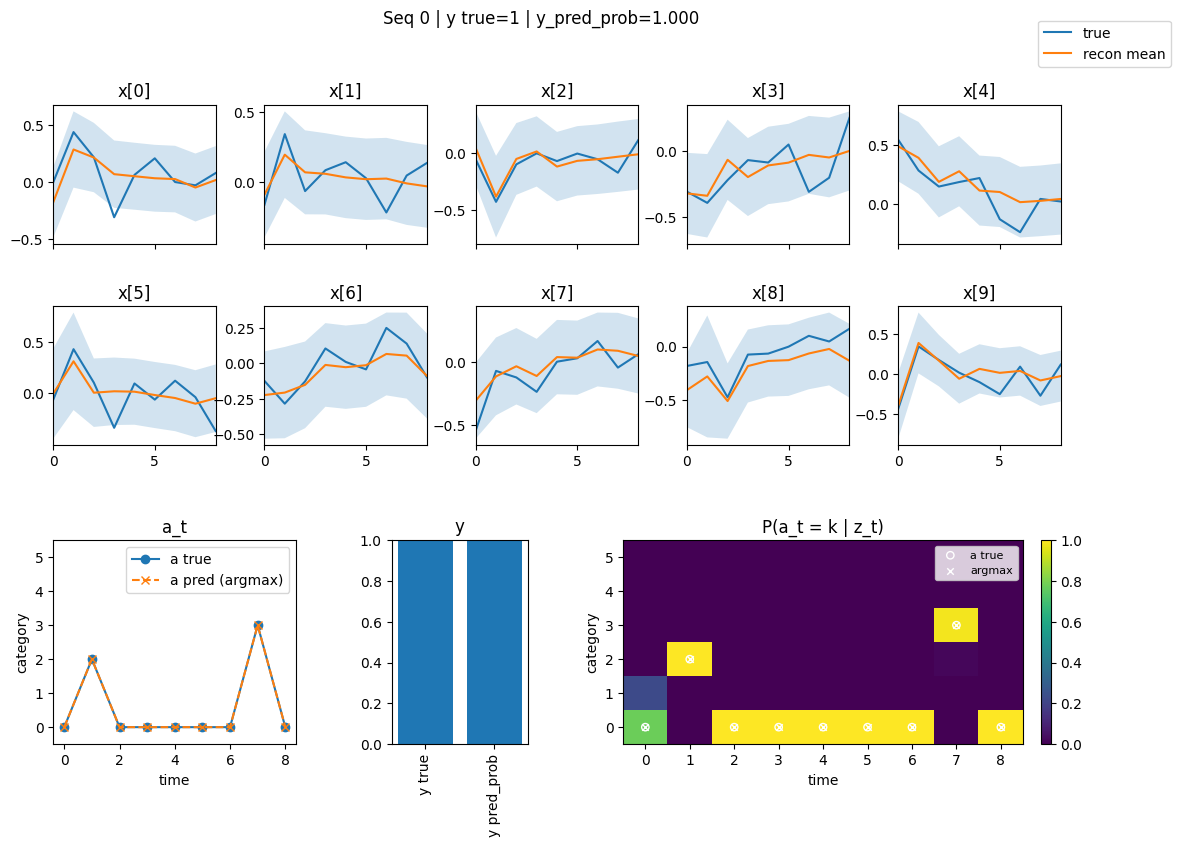

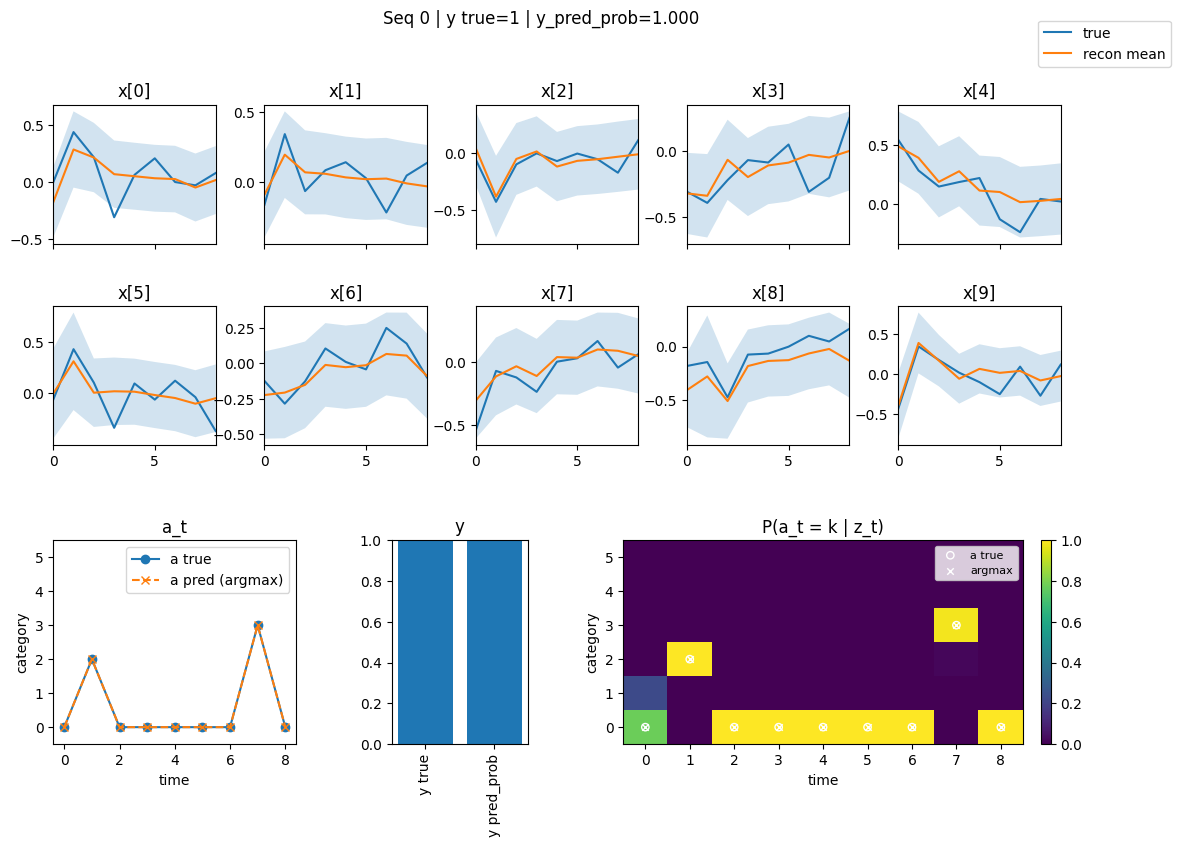

In [16]:
# visualize
i = 0
for xb, ab, yb, zb, lb, mb in test_loader:
    i+=1
    if i == 3: #2, 20
        break

model.plot_reconstruction_full(
    x=xb, a=ab, y=yb, lengths=lb, mask=mb,
    seq_idx=0,
    x_dims=(0, 1, 2,3,4,5,6,7,8,9),
    max_timepoints=None,
    show=True,
)

# Transfusion-Policy

# Transfusion-Policy (Stage II) built on Transfusion-ITE (Stage I)

This note documents:

- **What Stage II reuses from Stage I** (the trained Transfusion-ITE / DynVAE model)
- **How to explicitly reference** the reused structures/functions in code
- **How rollout horizons** in Stage II match each patient’s **ground-truth trajectory length** (including counterfactual rollouts)

---

## Stage I vs Stage II (high-level)

### Stage I (Transfusion-ITE / DynVAE)
Stage I trains a latent state-space model (world model) plus inference networks. After Stage I, you have:

- A **distilled filtering posterior** that infers a latent state from observed history
- A **latent transition model** that rolls the latent state forward under actions
- A **terminal outcome (risk) head** that predicts the outcome from terminal latent state and terminal action
- An **action model** that can be used as the **reference / behavior policy**

### Stage II (Transfusion-Policy)
Stage II *freezes* the Stage I model and trains:

- A new policy network **pi_psi(a | z)**
- A new value network **V_psi(z)** (critic)

Stage II uses the frozen Stage I model as a **latent simulator**: it initializes a latent state from history, rolls forward latents under counterfactual actions, and computes terminal risk.

---

## Reused components from Stage I (what they are, and how to call them)

Below is a direct mapping from the reused theoretical components to the concrete functions you call on your trained `DynVAE_CatA` instance (here named `ite_model`).

> Assumptions: categorical actions, no static covariates `v`.

### 1) Distilled filtering posterior  q_tilde(z_t | x_1:t, a_1:t-1)

**Role in Stage II:** produces the initial latent state at episode start (in `env.reset()`).

**Functions reused from Stage I:**

- `ite_model.a_emb(...)`  (action embedding)
- `ite_model.inf_rnn_fw(...)` (forward inference RNN for the history)
- `ite_model.q_tilde(f_t)` (maps final inference hidden state to Normal params for z_t)

**Minimal reference snippet:**

```python
# Build a_shift (length t): a_shift[0]=0, a_shift[1]=a_1, ..., a_shift[t-1]=a_{t-1}
a_shift = torch.zeros((t,), dtype=torch.long, device=device)
if t > 1:
    a_shift[1:] = a_hist_prev

# Encode history
w = torch.cat([x_hist, ite_model.a_emb(a_shift)], dim=-1).unsqueeze(0)  # (1,t,*)
f_init = ite_model.f0.expand(ite_model.num_layers, 1, ite_model.dim_f).contiguous()
f_seq, _ = ite_model.inf_rnn_fw(w, f_init)

# Distilled filter params + sample
f_t = f_seq[0, -1, :]
loc, scale = ite_model.q_tilde(f_t)
z_t = torch.distributions.Normal(loc, scale.clamp_min(1e-6)).sample()
```

### 2) Latent transition model  p_theta(z_{t+1} | z_t, a_t)

**Role in Stage II:** simulates the next latent state under the policy’s action (in `env.step(a)`). This is what makes counterfactual rollouts possible.

**Functions reused from Stage I:**

- `ite_model.a_emb(...)` (embed the chosen action)
- `ite_model.p_z(z_t, a_emb)` (maps to Normal params for the next latent)

**Minimal reference snippet:**

```python
a_idx = torch.tensor([a_t], dtype=torch.long, device=device)
a_emb = ite_model.a_emb(a_idx)
loc, scale = ite_model.p_z(z_t[None, :], a_emb)
z_next = torch.distributions.Normal(loc, scale.clamp_min(1e-6)).sample().squeeze(0)
```

### 3) Terminal outcome / risk head  p_theta(y | z_T, a_T)

**Role in Stage II:** converts the terminal latent state and terminal action into predicted outcome risk used for the terminal reward.

**Functions reused from Stage I:**

- `ite_model.p_y(concat([z_T, onehot(a_T)]))` (outputs Bernoulli logits)

**Minimal reference snippet:**

```python
a_onehot = F.one_hot(torch.tensor([a_T], device=device), num_classes=ite_model.K).float()
logits = ite_model.p_y(torch.cat([z_T[None, :], a_onehot], dim=-1))
risk = torch.sigmoid(logits).squeeze()
reward_terminal = -float(risk.item())
```

### 4) Reference / behavior policy  pi_theta(a | z) := p_theta(a | z)

**Role in Stage II:**

- **Reference KL regularization:** penalize deviation from the behavior-like policy
- **Optional shaping (Option II):** Monte Carlo rollouts under the reference policy to estimate potentials

**Functions reused from Stage I:**

- `ite_model.p_a(z)` (logits over categorical actions)

**Minimal reference snippet:**

```python
ref_logits = ite_model.p_a(z[None, :]).squeeze(0)
pi_theta = torch.softmax(ref_logits, dim=-1)
```

---

## Where Stage II calls the reused pieces (Gymnasium env wiring)

If you implement Stage II with a Gymnasium environment, the reuse pattern is:

### `env.reset()`

1. Sample a patient `i` from the dataset
2. Get ground-truth length `L` (from the dataset)
3. Sample a start time `t` (often uniform in [1..L])
4. Build history `x_1:t` and `a_1:t-1`
5. Infer latent state using the **distilled filtering posterior**:

- `ite_model.inf_rnn_fw` + `ite_model.q_tilde` + `ite_model.a_emb`

### `env.step(a_t)`

1. If this is not terminal:
   - Roll the latent state forward under the chosen action using the **latent transition**:

     - `ite_model.p_z` + `ite_model.a_emb`

2. If this is terminal (`steps_remaining == 1`):
   - Compute predicted risk using the **outcome head**:

     - `ite_model.p_y` (+ one-hot action)

3. (Optional) Use the **reference policy**:

- `ite_model.p_a` for KL regularization and/or potential shaping rollouts

---

## Patient-specific horizon (rollout length matches ground-truth)

**Requirement:** every rollout uses the same horizon as the sampled real trajectory, even when actions are counterfactual.

In Stage II, each episode uses:

- `L` = the ground-truth trajectory length for patient `i` from the dataset
- `t` = the sampled start time within that trajectory

Then define:

```text
steps_remaining = L - t + 1
```

**Termination condition:** the episode terminates when `steps_remaining == 1`, i.e., after exactly `(L - t + 1)` actions have been taken.

**Key point:** counterfactual rollouts only change the actions (and therefore the latent trajectory), not `L` or the countdown. The number of steps is fixed by the original data’s length.

### Normalizing time in observations
If your observation includes a time feature (e.g., remaining steps), normalize it by the patient’s `L` rather than a global `max_T`:

```python
rem_norm = steps_remaining / max(L, 1)
obs = concat([z_t, rem_norm])
```

---

## Freezing Stage I in Stage II (recommended)

In Stage II, you typically want Stage I to be a fixed simulator:

```python
ite_model.eval()
for p in ite_model.parameters():
    p.requires_grad_(False)

# And wrap simulator calls so you don’t build graphs:
with torch.no_grad():
    z_next = sample_next_z(ite_model, z, a)
```

---

## Quick reference (copy/paste mapping)

| Stage I concept | Stage II usage | Explicit function calls |
|---|---|---|
| Distilled filter q_tilde(z_t | H_t) | initialize latent at reset | `a_emb` + `inf_rnn_fw` + `q_tilde` |
| Transition p_theta(z_{t+1} | z_t, a_t) | latent simulator step | `a_emb` + `p_z` |
| Outcome p_theta(y | z_T, a_T) | terminal reward (negative risk) | `p_y` (+ one-hot a_T) |
| Reference policy pi_theta(a | z) | KL regularizer / shaping | `p_a` (+ softmax) |

---

## Minimal Stage II flow (one episode)

```python
# RESET
(i, x, a, L) = sample_patient_and_data()
t = sample_time_in_1_to_L()
x_hist = x[:t]
a_prev = a[:t-1]

z = sample_from_q_tilde(ite_model, x_hist, a_prev)  # uses inf_rnn_fw + q_tilde
steps_remaining = L - t + 1

# ROLLOUT
while steps_remaining > 1:
    a_cf = policy_pi_psi(z)
    z = sample_from_p_z(ite_model, z, a_cf)         # uses p_z
    steps_remaining -= 1

# TERMINAL
a_T = policy_pi_psi(z)
risk = sigmoid(p_y([z, onehot(a_T)]))               # uses p_y
reward = -risk
```


In [17]:
# =========================
# Transfusion-Policy (Stage II)
# Gymnasium env + PPO-Clip + reference KL regularization
# Works with your DynVAE_CatA (categorical actions, no v)
# =========================

from __future__ import annotations
from dataclasses import dataclass
from typing import Optional, Tuple, List, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym


# -------------------------
# 1) Helpers to use DynVAE_CatA as a latent simulator
# -------------------------

@torch.no_grad()
def infer_z_t_from_history(
    ite_model,                      # DynVAE_CatA
    x_hist: torch.Tensor,           # (t, dim_x) float32
    a_hist_prev: torch.Tensor,      # (t-1,) long  actions a_1...(t-1)
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Implements distilled filtering posterior q_tilde(z_t | H_t),
    where H_t = {x_1:t, a_1:t-1}. (v omitted)

    Returns (loc, scale) for Normal over z_t: both (dim_z,).
    """
    device = ite_model.device
    ite_model.eval()

    t = x_hist.shape[0]
    x_hist = x_hist.to(device)

    # Build a_shift for length t:
    # a_shift[0] = 0, a_shift[1] = a_1, ..., a_shift[t-1] = a_{t-1}
    a_shift = torch.zeros((t,), dtype=torch.long, device=device)
    if t > 1:
        a_shift[1:] = a_hist_prev.to(device)

    a_shift_emb = ite_model.a_emb(a_shift)                       # (t, a_emb_dim)
    w = torch.cat([x_hist, a_shift_emb], dim=-1).unsqueeze(0)    # (1, t, dim_x+a_emb_dim)

    # Initial hidden state for forward GRU
    # ite_model.f0 is (num_layers, 1, dim_f)
    f_init = ite_model.f0.expand(ite_model.num_layers, 1, ite_model.dim_f).contiguous()

    f_seq, _ = ite_model.inf_rnn_fw(w, f_init)   # (1, t, dim_f)
    f_t = f_seq[0, t - 1, :]                     # (dim_f,)

    loc, scale = ite_model.q_tilde(f_t)          # each (dim_z,)
    scale = torch.clamp(scale, min=1e-6)
    return loc, scale


@torch.no_grad()
def sample_next_z(ite_model, z: torch.Tensor, a: int) -> torch.Tensor:
    """
    z_{t+1} ~ p_theta(z_{t+1} | z_t, a_t)  (v omitted)
    """
    device = ite_model.device
    ite_model.eval()

    z = z.to(device).unsqueeze(0)  # (1, dim_z)
    a_idx = torch.tensor([a], dtype=torch.long, device=device)   # (1,)
    a_emb = ite_model.a_emb(a_idx)                               # (1, a_emb_dim)

    loc, scale = ite_model.p_z(z, a_emb)                         # (1, dim_z), (1, dim_z)
    scale = torch.clamp(scale, min=1e-6)
    z_next = torch.distributions.Normal(loc, scale).sample()     # (1, dim_z)
    return z_next.squeeze(0)


@torch.no_grad()
def reference_action_probs(ite_model, z: torch.Tensor) -> torch.Tensor:
    """
    pi_theta(a|z) = p_theta(a|z) from the learned assignment model p_a.
    Returns probs (K,)
    """
    device = ite_model.device
    ite_model.eval()
    z = z.to(device).unsqueeze(0)                 # (1, dim_z)
    logits = ite_model.p_a(z).squeeze(0)          # (K,)
    return torch.softmax(logits, dim=-1)


@torch.no_grad()
def terminal_risk_prob(ite_model, z_T: torch.Tensor, a_T: int) -> torch.Tensor:
    """
    p_theta(y=1 | z_T, a_T) using p_y([z_T, onehot(a_T)]).
    Returns scalar tensor in [0,1].
    """
    device = ite_model.device
    ite_model.eval()
    z_T = z_T.to(device).unsqueeze(0)  # (1, dim_z)

    a_onehot = F.one_hot(
        torch.tensor([a_T], dtype=torch.long, device=device),
        num_classes=ite_model.K
    ).float()  # (1, K)

    logits = ite_model.p_y(torch.cat([z_T, a_onehot], dim=-1))    # (1,1)
    prob = torch.sigmoid(logits).squeeze(0).squeeze(0)
    return prob


# -------------------------
# 2) Reward options (paper Eq. 12/13/14)
# -------------------------

def action_cost(a: int, dose_values: Optional[np.ndarray] = None) -> float:
    """
    c(a_t) in Eq (12).
    If dose_values is provided (shape K,), use that dose magnitude; else use a itself.
    """
    if dose_values is None:
        return float(a)
    return float(dose_values[a])


@torch.no_grad()
def phi_reference_mc(
    ite_model,
    z: torch.Tensor,
    steps_remaining: int,
    n_rollouts: int = 8,
) -> float:
    """
    Option II potential Phi_t(z_t) := E[-y | z_t, a_{t:T} ~ pi_theta] (Eq. 13).
    We estimate by Monte Carlo rollouts under reference policy pi_theta = p_a.

    NOTE: This potential depends on horizon via steps_remaining.
    """
    if steps_remaining <= 0:
        return 0.0

    device = ite_model.device
    z0 = z.to(device)

    risks = []
    for _ in range(n_rollouts):
        z_cur = z0.clone()
        a_last = 0
        for k in range(steps_remaining):
            # sample a ~ pi_theta(a|z)
            probs = reference_action_probs(ite_model, z_cur)     # (K,)
            a = int(torch.multinomial(probs, num_samples=1).item())
            a_last = a

            # transition unless this is terminal decision
            if k < steps_remaining - 1:
                z_cur = sample_next_z(ite_model, z_cur, a)

        risk = float(terminal_risk_prob(ite_model, z_cur, a_last).item())
        risks.append(risk)

    # Phi = E[-y] ~ -E[risk]
    return -float(np.mean(risks))


# -------------------------
# 3) Gymnasium environment
# -------------------------

class TransfusionLatentEnv(gym.Env):
    """
    Episodic env:
      - reset(): sample patient i and start time t, infer z_t ~ q_tilde(z_t | H_t)
      - step(a): simulate z_{t+1} ~ p_theta(z_{t+1}|z_t,a), terminal risk from p_theta(y|z_T,a_T)
    Observation: [z_t, remaining_steps_norm]
    Action space: Discrete(K)
    """

    metadata = {"render_modes": []}

    def __init__(
        self,
        ite_model,
        dataset,                         # your SimDataset or similar
        max_T: int,
        gamma: float = 1.0,
        beta: float = 0.0,
        reward_mode: str = "option1",    # {"option1","option2","option3"} (option3 uses critic shaping; implemented in trainer)
        dose_values: Optional[np.ndarray] = None,
        phi_rollouts: int = 8,
        seed: int = 0,
    ):
        super().__init__()
        assert reward_mode in {"option1", "option2", "option3"}

        self.ite_model = ite_model
        self.dataset = dataset
        self.max_T = int(max_T)
        self.gamma = float(gamma)
        self.beta = float(beta)
        self.reward_mode = reward_mode
        self.dose_values = dose_values
        self.phi_rollouts = int(phi_rollouts)

        self.K = int(ite_model.K)
        self.dim_z = int(ite_model.dim_z)

        self.action_space = gym.spaces.Discrete(self.K)
        # z can be unbounded, we just set large bounds
        obs_dim = self.dim_z + 1
        self.observation_space = gym.spaces.Box(
            low=-1e9, high=1e9, shape=(obs_dim,), dtype=np.float32
        )

        self.np_random, _ = gym.utils.seeding.np_random(seed)

        # episode state
        self._z = None
        self._steps_remaining = None

        # Option II potential cache (lightweight, horizon-aware)
        self._phi_cache: Dict[Tuple[int, int], float] = {}

    def _obs(self) -> np.ndarray:
        z = self._z.detach().cpu().numpy().astype(np.float32)
        rem_norm = np.array([self._steps_remaining / max(self.max_T, 1)], dtype=np.float32)
        return np.concatenate([z, rem_norm], axis=0)

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        if seed is not None:
            self.np_random, _ = gym.utils.seeding.np_random(seed)

        # Sample patient i and time index t (Algorithm 1 Stage II) :contentReference[oaicite:15]{index=15}
        i = int(self.np_random.integers(0, len(self.dataset)))
        x, a, y, z_true, length = self.dataset[i]  # matches your SimDataset :contentReference[oaicite:16]{index=16}
        L = int(length.item()) if torch.is_tensor(length) else int(length)

        # choose t in [1..L] (1-indexed in paper)
        t = int(self.np_random.integers(1, L + 1))

        x_hist = x[:t, :]               # (t, dim_x)
        a_hist_prev = a[: max(t - 1, 0)]  # (t-1,)

        loc, scale = infer_z_t_from_history(self.ite_model, x_hist, a_hist_prev)
        z_t = torch.distributions.Normal(loc, scale).sample()

        self._z = z_t
        self._steps_remaining = (L - t + 1)

        info = {"patient_index": i, "t": t, "traj_len": L}
        return self._obs(), info

    def step(self, action: int):
        a = int(action)
        rem = int(self._steps_remaining)

        # Base reward option I (Eq. 12) :contentReference[oaicite:17]{index=17}
        base = -self.beta * action_cost(a, self.dose_values)

        terminated = False
        truncated = False
        info = {}

        if rem <= 1:
            # terminal decision: use predicted risk
            risk = float(terminal_risk_prob(self.ite_model, self._z, a).item())
            base = -risk - self.beta * action_cost(a, self.dose_values)
            terminated = True

            # Option II shaping: treat next state's potential as 0 (absorbing)
            if self.reward_mode == "option2":
                phi_cur = phi_reference_mc(self.ite_model, self._z, steps_remaining=1, n_rollouts=self.phi_rollouts)
                shaped = base + self.gamma * 0.0 - phi_cur
                reward = float(shaped)
            else:
                reward = float(base)

            # keep z as-is (unused after termination)
            obs = self._obs()
            return obs, reward, terminated, truncated, info

        # Non-terminal: simulate next latent state
        z_next = sample_next_z(self.ite_model, self._z, a)

        # Option II (fixed-potential shaping) Eq. 13 :contentReference[oaicite:18]{index=18}
        if self.reward_mode == "option2":
            # cache by (horizon, coarse_z_hash) to avoid repeated MC in same neighborhood
            def _hash_z(z: torch.Tensor, decimals: int = 2) -> int:
                zz = torch.round(z.detach().cpu() * (10 ** decimals)).to(torch.int32).numpy()
                return hash(zz.tobytes())

            key_cur = (_hash_z(self._z), rem)
            key_nxt = (_hash_z(z_next), rem - 1)

            if key_cur not in self._phi_cache:
                self._phi_cache[key_cur] = phi_reference_mc(
                    self.ite_model, self._z, steps_remaining=rem, n_rollouts=self.phi_rollouts
                )
            if key_nxt not in self._phi_cache:
                self._phi_cache[key_nxt] = phi_reference_mc(
                    self.ite_model, z_next, steps_remaining=rem - 1, n_rollouts=self.phi_rollouts
                )

            phi_cur = self._phi_cache[key_cur]
            phi_nxt = self._phi_cache[key_nxt]
            reward = float(base + self.gamma * phi_nxt - phi_cur)
        else:
            reward = float(base)

        # advance
        self._z = z_next
        self._steps_remaining = rem - 1

        return self._obs(), reward, terminated, truncated, info


# -------------------------
# 4) Policy + Value networks
# -------------------------

class PolicyNet(nn.Module):
    def __init__(self, obs_dim: int, K: int, hidden: int = 128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, K),
        )

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        return self.net(obs)  # logits


class ValueNet(nn.Module):
    def __init__(self, obs_dim: int, hidden: int = 128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, 1),
        )

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        return self.net(obs).squeeze(-1)  # (batch,)


# -------------------------
# 5) PPO utilities
# -------------------------

@dataclass
class RolloutBatch:
    obs: torch.Tensor
    act: torch.Tensor
    logp_old: torch.Tensor
    ret: torch.Tensor
    adv: torch.Tensor


def compute_gae(rewards, values, dones, gamma=0.99, lam=0.95):
    """
    rewards, values, dones: 1D tensors length T
    returns advantages and returns
    """
    T = rewards.shape[0]
    adv = torch.zeros_like(rewards)
    last_gae = 0.0
    next_value = 0.0

    for t in reversed(range(T)):
        nonterminal = 1.0 - dones[t]
        delta = rewards[t] + gamma * next_value * nonterminal - values[t]
        last_gae = delta + gamma * lam * nonterminal * last_gae
        adv[t] = last_gae
        next_value = values[t]

    ret = adv + values
    return adv, ret


@torch.no_grad()
def ref_kl_pi_psi_vs_pi_theta(
    ite_model,
    z_only: torch.Tensor,            # (B, dim_z)  (NOT including time scalar)
    pi_psi_logits: torch.Tensor,     # (B, K)
) -> torch.Tensor:
    """
    D_KL( pi_psi(.|z) || pi_theta(.|z) ) per state.
    Uses pi_theta from ite_model.p_a (reference policy) :contentReference[oaicite:19]{index=19}
    """
    device = pi_psi_logits.device
    z_only = z_only.to(ite_model.device)

    # reference logits from ite_model.p_a
    ref_logits = ite_model.p_a(z_only).to(device)  # (B,K)

    logp = F.log_softmax(pi_psi_logits, dim=-1)
    p = torch.softmax(pi_psi_logits, dim=-1)
    logq = F.log_softmax(ref_logits, dim=-1)

    kl = torch.sum(p * (logp - logq), dim=-1)  # (B,)
    return kl


def ppo_update(
    ite_model,
    policy: PolicyNet,
    value_fn: ValueNet,
    optimizer_pi: torch.optim.Optimizer,
    optimizer_v: torch.optim.Optimizer,
    batch: RolloutBatch,
    clip_eps: float = 0.2,
    alpha_refkl: float = 0.1,     # reference KL weight (Eq. 15) :contentReference[oaicite:20]{index=20}
    ent_coef: float = 0.0,
    vf_coef: float = 0.5,
    max_grad_norm: float = 1.0,
):
    obs = batch.obs
    act = batch.act
    logp_old = batch.logp_old
    adv = batch.adv
    ret = batch.ret

    # normalize advantages
    adv = (adv - adv.mean()) / (adv.std() + 1e-8)

    # --- policy loss (PPO-Clip) ---
    logits = policy(obs)
    dist = torch.distributions.Categorical(logits=logits)
    logp = dist.log_prob(act)

    ratio = torch.exp(logp - logp_old)
    surr1 = ratio * adv
    surr2 = torch.clamp(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * adv
    ppo_obj = torch.min(surr1, surr2).mean()

    # reference KL regularizer (Eq. 15) :contentReference[oaicite:21]{index=21}
    # obs = [z, rem_norm] -> extract z part
    z_part = obs[:, : ite_model.dim_z].to(ite_model.device)
    kl_ref = ref_kl_pi_psi_vs_pi_theta(ite_model, z_part, logits).mean()

    entropy = dist.entropy().mean()

    loss_pi = -(ppo_obj - alpha_refkl * kl_ref + ent_coef * entropy)

    optimizer_pi.zero_grad(set_to_none=True)
    loss_pi.backward()
    nn.utils.clip_grad_norm_(policy.parameters(), max_grad_norm)
    optimizer_pi.step()

    # --- value loss (Eq. 16) :contentReference[oaicite:22]{index=22} ---
    v = value_fn(obs)
    loss_v = F.mse_loss(v, ret)

    optimizer_v.zero_grad(set_to_none=True)
    (vf_coef * loss_v).backward()
    nn.utils.clip_grad_norm_(value_fn.parameters(), max_grad_norm)
    optimizer_v.step()

    return {
        "loss_pi": float(loss_pi.item()),
        "loss_v": float(loss_v.item()),
        "ppo_obj": float(ppo_obj.item()),
        "kl_ref": float(kl_ref.item()),
        "entropy": float(entropy.item()),
    }


def train_transfusion_policy(
    env: TransfusionLatentEnv,
    ite_model,
    device: str = "cpu",
    total_steps: int = 200_000,
    rollout_steps: int = 2048,
    update_epochs: int = 10,
    minibatch_size: int = 256,
    gamma: float = 1.0,
    gae_lambda: float = 0.95,
    lr_pi: float = 3e-4,
    lr_v: float = 1e-3,
    clip_eps: float = 0.2,
    alpha_refkl: float = 0.1,
    hidden: int = 128,
    log_every_updates: int = 10,
):
    obs_dim = env.observation_space.shape[0]
    K = env.action_space.n

    policy = PolicyNet(obs_dim, K, hidden=hidden).to(device)
    value_fn = ValueNet(obs_dim, hidden=hidden).to(device)

    opt_pi = torch.optim.Adam(policy.parameters(), lr=lr_pi)
    opt_v = torch.optim.Adam(value_fn.parameters(), lr=lr_v)

    obs_np, _ = env.reset()
    obs = torch.tensor(obs_np, dtype=torch.float32, device=device)

    n_updates = total_steps // rollout_steps

    for upd in range(1, n_updates + 1):
        # collect rollouts with current policy pi_{psi_k} (Algorithm 1) :contentReference[oaicite:23]{index=23}
        obs_buf = []
        act_buf = []
        logp_buf = []
        rew_buf = []
        done_buf = []
        val_buf = []

        for _ in range(rollout_steps):
            with torch.no_grad():
                logits = policy(obs.unsqueeze(0))  # (1,K)
                dist = torch.distributions.Categorical(logits=logits)
                act = dist.sample().squeeze(0)
                logp = dist.log_prob(act.unsqueeze(0)).squeeze(0)
                val = value_fn(obs.unsqueeze(0)).squeeze(0)

            next_obs_np, rew, terminated, truncated, _ = env.step(int(act.item()))
            done = float(terminated or truncated)

            obs_buf.append(obs)
            act_buf.append(act)
            logp_buf.append(logp)
            rew_buf.append(torch.tensor(rew, dtype=torch.float32, device=device))
            done_buf.append(torch.tensor(done, dtype=torch.float32, device=device))
            val_buf.append(val)

            if done:
                next_obs_np, _ = env.reset()

            obs = torch.tensor(next_obs_np, dtype=torch.float32, device=device)

        obs_t = torch.stack(obs_buf)                 # (T, obs_dim)
        act_t = torch.stack(act_buf)                 # (T,)
        logp_old_t = torch.stack(logp_buf)           # (T,)
        rew_t = torch.stack(rew_buf)                 # (T,)
        done_t = torch.stack(done_buf)               # (T,)
        val_t = torch.stack(val_buf)                 # (T,)

        adv_t, ret_t = compute_gae(rew_t, val_t, done_t, gamma=gamma, lam=gae_lambda)

        # flatten
        N = rollout_steps
        idx = torch.randperm(N, device=device)

        # multiple epochs of minibatch SGD
        metrics_accum = {"loss_pi": 0.0, "loss_v": 0.0, "ppo_obj": 0.0, "kl_ref": 0.0, "entropy": 0.0}
        n_mb = 0

        for _ in range(update_epochs):
            for start in range(0, N, minibatch_size):
                mb_idx = idx[start : start + minibatch_size]

                batch = RolloutBatch(
                    obs=obs_t[mb_idx],
                    act=act_t[mb_idx],
                    logp_old=logp_old_t[mb_idx],
                    adv=adv_t[mb_idx],
                    ret=ret_t[mb_idx],
                )

                m = ppo_update(
                    ite_model=ite_model,
                    policy=policy,
                    value_fn=value_fn,
                    optimizer_pi=opt_pi,
                    optimizer_v=opt_v,
                    batch=batch,
                    clip_eps=clip_eps,
                    alpha_refkl=alpha_refkl,
                )
                for k in metrics_accum:
                    metrics_accum[k] += m[k]
                n_mb += 1

        for k in metrics_accum:
            metrics_accum[k] /= max(n_mb, 1)

        if upd % log_every_updates == 0:
            print(f"[upd {upd:4d}/{n_updates}] "
                  f"pi={metrics_accum['loss_pi']:.4f} v={metrics_accum['loss_v']:.4f} "
                  f"ppo={metrics_accum['ppo_obj']:.4f} kl_ref={metrics_accum['kl_ref']:.4f} ent={metrics_accum['entropy']:.4f}")

    return policy, value_fn



In [18]:
# -------------------------
# 6) Example usage with your SimDataset + trained DynVAE_CatA
# -------------------------
# Assuming:
#   - `model` is your trained DynVAE_CatA
#   - `train_dataset` is your SimDataset split
#   - max_T = the simulator max length (e.g., 15)

env = TransfusionLatentEnv(
    ite_model=model,
    dataset=train_dataset,
    max_T=15,
    gamma=1.0,
    beta=0.0,                 # Eq (12) dose penalty weight :contentReference[oaicite:24]{index=24}
    reward_mode="option1",    # option1: sparse terminal risk (Eq 12) :contentReference[oaicite:25]{index=25}
    phi_rollouts=8,
    seed=0,
)

policy, value_fn = train_transfusion_policy(
    env=env,
    ite_model=model,
    device="cuda" if torch.cuda.is_available() else "cpu",
    total_steps=200_000,
    rollout_steps=2048,
    update_epochs=10,
    minibatch_size=256,
    gamma=1.0,
    gae_lambda=0.95,
    alpha_refkl=0.1,          # reference KL weight (Eq 15) :contentReference[oaicite:26]{index=26}
)
#
# torch.save(policy.state_dict(), "transfusion_policy.pt")

[upd   10/97] pi=0.7379 v=0.0653 ppo=0.0158 kl_ref=7.5366 ent=1.0696
[upd   20/97] pi=0.7461 v=0.0228 ppo=0.0079 kl_ref=7.5397 ent=0.7759


KeyboardInterrupt: 